In [2]:
!pip install python-terrier
import math
import gensim
import pyterrier as pt
import re
import numpy as np
import json
import pandas as pd
import math
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
from SPARQLWrapper import SPARQLWrapper, JSON
import warnings
warnings.filterwarnings("ignore")
import wikipedia
import gensim.downloader as api
import random
from pyrdf2vec.graphs import KG
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.samplers import UniformSampler
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.walkers import RandomWalker
from utils import * 

if not pt.started():
    pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


## Chargement des tables et des requetes

In [3]:
with open('tables_1000.json', 'r') as f:
  # Charger les données JSON dans un dictionnaire Python
  tables = json.load(f)
    
# Ouvrir le fichier en mode lecture
with open('requetes_20.json', 'r') as f:
  # Charger les données JSON dans un dictionnaire Python
  queries = json.load(f)

# Experimentations

In [5]:
corpus = tables['tables']
nb_tables = 1000
nb_queries = 20

In [6]:
vocabulaire = []
for i in range(nb_tables):
    table = corpus[i]
    content_word = content_extraction(table,base='word')
    vocabulaire.extend(content_word)
    
vocabulaire = set(vocabulaire)

### Unsupervised Ranking

In [19]:
scores_unsu_ran_sin = []
scores_unsu_ran_mul = []

for i,table in enumerate(corpus):
    print(f"\nPour la table {i} ")
    q = query
    print("Score BM25 en utilisant le ranking non supervisé en single field : ",unsuprvised_ranking(table,q))
    scores_unsu_ran_sin.append(unsuprvised_ranking(table,q))
    print("Score BM25 en utilisant le ranking non supervisé en multi field (poids uniforms): ",unsuprvised_ranking(table,q,False))
    scores_unsu_ran_mul.append(unsuprvised_ranking(table,q,False))
    print("Score BM25 en utilisant le ranking non supervisé en multi field (poids non uniforms): ",unsuprvised_ranking(table,q,False,[0.1,0.1,0.1,0.1,0.6]))


Pour la table 0 
Score BM25 en utilisant le ranking non supervisé en single field :  0
Score BM25 en utilisant le ranking non supervisé en multi field (poids uniforms):  0.0
Score BM25 en utilisant le ranking non supervisé en multi field (poids non uniforms):  0.0

Pour la table 1 
Score BM25 en utilisant le ranking non supervisé en single field :  4.394449154672439
Score BM25 en utilisant le ranking non supervisé en multi field (poids uniforms):  0.2716246968306389
Score BM25 en utilisant le ranking non supervisé en multi field (poids non uniforms):  0.13581234841531944

Pour la table 2 
Score BM25 en utilisant le ranking non supervisé en single field :  0
Score BM25 en utilisant le ranking non supervisé en multi field (poids uniforms):  0.0
Score BM25 en utilisant le ranking non supervisé en multi field (poids non uniforms):  0.0

Pour la table 3 
Score BM25 en utilisant le ranking non supervisé en single field :  2.9789251552376097
Score BM25 en utilisant le ranking non supervisé e

In [20]:
ndcg_unsu_rank_sin = []
indices_best_tables = np.argsort(scores_unsu_ran_sin)[::-1]
print("\nSCORE UNSUPERVISED RANKING")
K = [5,6,7,8]
for k in K:
    corpus = np.array(corpus)
    corpus_best = corpus[indices_best_tables]

    relevances = get_relevance(corpus_best)[:k]

    ranking = np.arange(len(relevances))
    score_ndcg = ndcg(ranking,relevances,k)
    ndcg_unsu_rank_sin.append(score_ndcg)
    print(f"NDCG@{k} = ", score_ndcg)
    
    
    
ndcg_unsu_rank_mul = []
indices_best_tables = np.argsort(scores_unsu_ran_mul)[::-1]
print("\nSCORE UNSUPERVISED RANKING")
K = [5,6,7,8]
for k in K:
    corpus = np.array(corpus)
    corpus_best = corpus[indices_best_tables]

    relevances = get_relevance(corpus_best)[:k]

    ranking = np.arange(len(relevances))
    score_ndcg = ndcg(ranking,relevances,k)
    ndcg_unsu_rank_mul.append(score_ndcg)
    print(f"NDCG@{k} = ", score_ndcg)


SCORE UNSUPERVISED RANKING
NDCG@5 =  0.6176324474063534
NDCG@6 =  0.6305224050669415
NDCG@7 =  0.6418215600978554
NDCG@8 =  0.651896411005132

SCORE UNSUPERVISED RANKING
NDCG@5 =  0.666953939877106
NDCG@6 =  0.6781812252073862
NDCG@7 =  0.6880229051308991
NDCG@8 =  0.6967982036054533


## Content Extraction

### Word Based

In [21]:
tables_content_WB = []
for i in range(nb_tables):
    table = tables['tables'][i]
    content_word = content_extraction(table,base='word')
    tables_content_WB.append(content_word)
    
query_content_WB = []
for i in range(nb_queries):
    content_word = content_extraction(query,base='word',query=True)
    query_content_WB.append(content_word)

#### Pour les tables

In [22]:
print("EN BASE WORD")
for i in range(11):
    print(f"\nLe contenu pour la table {i} : ")
    print(tables_content_WB[i])

EN BASE WORD

Le contenu pour la table 0 : 
{'cramer', 'positions', 'external', 'dettmar', 'sporting', 'links'}

Le contenu pour la table 1 : 
{'data', 'climate', 'burma', 'katha', 'for'}

Le contenu pour la table 2 : 
{'of', 'chart', 'november', 'year', 'gone', 'charts', 'end', '1998', 'till', 'position'}

Le contenu pour la table 3 : 
{'2006', 'charts', 'song', 'mikazuki', 'peak', 'chart', 'position'}

Le contenu pour la table 4 : 
{'latitude', 'diameter', 'crater', 'satellite', 'craters', 'longitude', 'sabine'}

Le contenu pour la table 5 : 
{'latitude', 'diameter', 'crater', 'satellite', 'secchi', 'craters', 'lunar', 'longitude'}

Le contenu pour la table 6 : 
{'latitude', 'diameter', 'crater', 'satellite', 'silberschlag', 'craters', 'longitude'}

Le contenu pour la table 7 : 
{'the', 'attendances', 'season', 'division', 'average', 'london', 'valley'}

Le contenu pour la table 8 : 
{'the', 'attendances', 'season', 'division', 'average', 'london', 'valley'}

Le contenu pour la table

## Semantic Representation

### Graph Embeddings

In [23]:
tables_ge = []
for i in range(nb_tables):
    table = tables['tables'][i]
    content_entity_ge = semantic_representation(tables_content_WB[i],'nothing',space='ge')
    tables_ge.append(content_entity_ge)
    
query_ge = []
for i in range(nb_queries):
    content_entity_ge = semantic_representation(query_content_WB[i],'nothing',space='ge')
    query_ge.append(content_entity_ge)

In [24]:
print("STRATEGY EARLY")
scores_early = []
for i in range(11):
    simi = similarity(tables_ge[i],query_ge[i],strategy='early',aggr='avg',isEmbedding=False)
    print(f"Similarity entre la table {i} et la requete {i} : " , simi)
    scores_early.append(simi)
    
    
print("\nSTRATEGY LATE-MAX")
for i in range(11):
    simi = similarity(tables_ge[i],query_ge[i],strategy='late',aggr='max',isEmbedding=False)
    print(f"Similarity entre la table {i} et la requete {i} : " , simi)
    
print("\nSTRATEGY LATE-SUM")
for i in range(11):
    simi = similarity(tables_ge[i],query_ge[i],strategy='late',aggr='sum',isEmbedding=False)
    print(f"Similarity entre la table {i} et la requete {i} : " , simi)
    
    
scores_late_average = []
print("\nSTRATEGY LATE-AVG")
for i in range(11):
    simi = similarity(tables_ge[i],query_ge[i],strategy='late',aggr='avg',isEmbedding=False)
    print(f"Similarity entre la table {i} et la requete {i} : " , simi)
    scores_late_average.append(simi)

STRATEGY EARLY
Similarity entre la table 0 et la requete 0 :  0.06369308256643098
Similarity entre la table 1 et la requete 1 :  0.5080894666695157
Similarity entre la table 2 et la requete 2 :  -0.04645034122681875
Similarity entre la table 3 et la requete 3 :  0.14700092275266124
Similarity entre la table 4 et la requete 4 :  0.037344964202482754
Similarity entre la table 5 et la requete 5 :  -0.03306831354507589
Similarity entre la table 6 et la requete 6 :  0.06731543345895698
Similarity entre la table 7 et la requete 7 :  0.1471482224280943
Similarity entre la table 8 et la requete 8 :  0.1471482224280943
Similarity entre la table 9 et la requete 9 :  0.1471482224280943
Similarity entre la table 10 et la requete 10 :  0.0445794578874837

STRATEGY LATE-MAX
Similarity entre la table 0 et la requete 0 :  0.24813229487309613
Similarity entre la table 1 et la requete 1 :  0.9993323881059423
Similarity entre la table 2 et la requete 2 :  0.17959366908650945
Similarity entre la table 3 e

## Relevance Assessements

In [25]:
ndcg_late_average = []
indices_best_tables = np.argsort(scores_late_average)[::-1]
print("\nSCORE LATE AVERAGE")
K = [5,6,7,8]

for k in K:
    corpus = np.array(corpus)
    corpus_best = corpus[indices_best_tables]

    relevances = get_relevance(corpus_best)[:k]

    ranking = np.arange(len(relevances))
    score_ndcg = ndcg(ranking,relevances,k)
    ndcg_late_average.append(score_ndcg)
    print(f"NDCG@{k} = ", score_ndcg)

    
ndcg_early = []
        
indices_best_tables = np.argsort(scores_early)[::-1]
print("\nSCORE EARLY")
K = [5,6,7,8]


for k in K:
    corpus = np.array(corpus)
    corpus_best = corpus[indices_best_tables]

    relevances = get_relevance(corpus_best)[:k]

    ranking = np.arange(len(relevances))
    score_ndcg = ndcg(ranking,relevances,k)
    ndcg_early.append(score_ndcg)
    print(f"NDCG@{k} = ", score_ndcg)


SCORE LATE AVERAGE
NDCG@5 =  0.666953939877106
NDCG@6 =  0.6781812252073862
NDCG@7 =  0.6862282420007412
NDCG@8 =  0.6943315038370774

SCORE EARLY
NDCG@5 =  0.7574727022325188
NDCG@6 =  0.7656485178281531
NDCG@7 =  0.7638951617437882
NDCG@8 =  0.7699926490938779


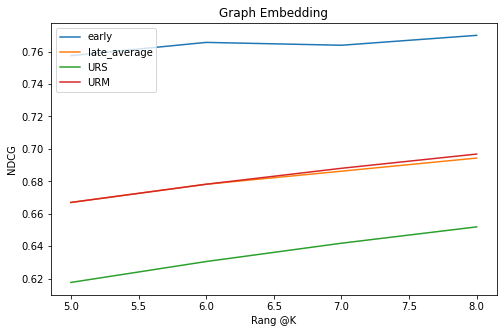

In [32]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
plt.title("Graph Embedding")
plt.xlabel("Rang @K")
plt.ylabel("NDCG")
plt.plot(K,ndcg_early)
plt.plot(K,ndcg_late_average)
plt.plot(K,ndcg_unsu_rank_sin)
plt.plot(K,ndcg_unsu_rank_mul)
plt.legend(["early","late_average","URS","URM"],loc='upper left')
plt.show()